# Решающие деревья

Покажем как работают деревья на модельных данных

In [236]:
%pylab inline
import numpy as np
import pandas as pd
import pylab as plt
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set(style='whitegrid')

Populating the interactive namespace from numpy and matplotlib


In [237]:
from sklearn.datasets import make_moons

##### Сгенерируем классы в форме полумесяцев

In [238]:
X,Y = make_moons(n_samples=300, shuffle=True, noise=0.4, random_state=0)

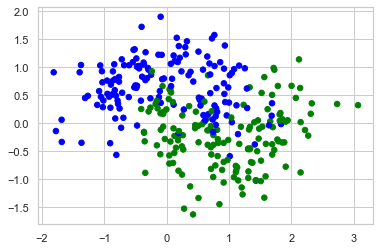

In [244]:
class2color={0:'blue',1:'green'}

scatter(X[:,0], X[:,1], color=[class2color[y] for y in Y], s=30)

In [240]:
X_train=X[::2]
Y_train=Y[::2]

X_test=X[1::2]
Y_test=Y[1::2]

In [241]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from utility import plot_predictions_2D
m = DecisionTreeClassifier(max_depth=20)
m.fit(X_train,Y_train)
Y_hat = m.predict(X_test)
accuracy = accuracy_score(Y_hat,Y_test)
#plot_predictions_2D(m, X_train, Y_train, task='classification', n=150, train=False, title='accuracy:%.3f'%accuracy)

##### Посмотрим как будет выглядить разделение плоскости в зависимости от 
- минимального количества объектов в листе
- максимальной глубины дерева

In [242]:
data_x=X_train
data_y=Y_train

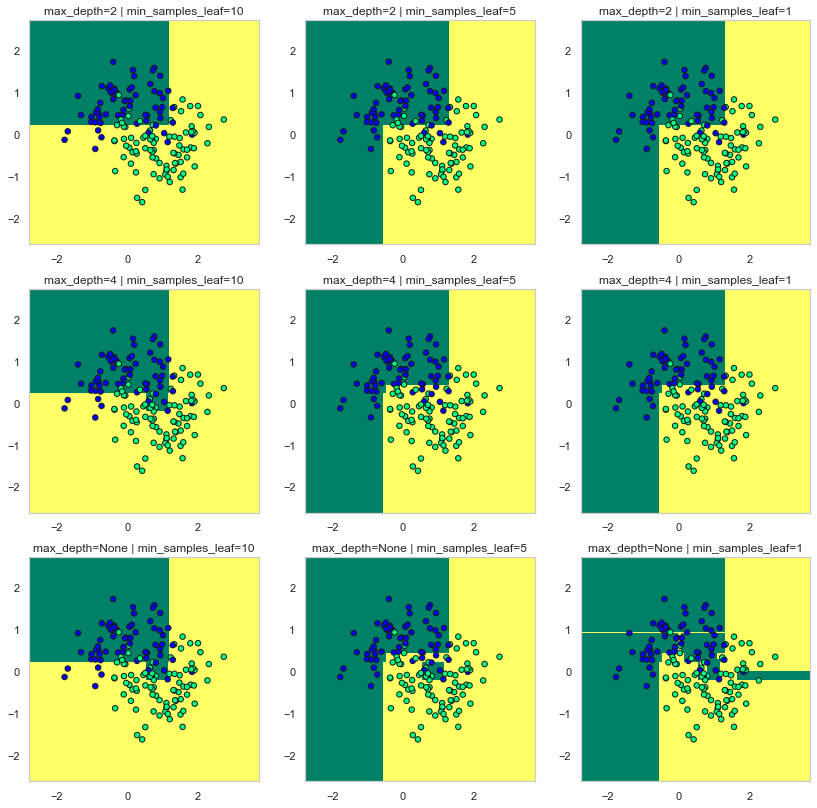

In [243]:
plt.figure(figsize=(14, 14))
for i, max_depth in enumerate([2, 4, None]):
    for j, min_samples_leaf in enumerate([10, 5, 1]):
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(data_x, data_y)
        xx, yy = get_grid(data_x)
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
        plt.subplot2grid((3, 3), (i, j))
        plt.pcolormesh(xx, yy, predicted, cmap='summer')
        plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='winter', edgecolor='k')
        plt.title('max_depth=' + str(max_depth) + ' | min_samples_leaf=' + str(min_samples_leaf))

- Увеличение максимальной глубины и/или уменьшение минимального количества объектов выборки в листе приводит к увеличению качества на обучающей выборке и переобучению.

* Если для регуляризации использовать только `max_depth` во многих листьях очень малая часть объектов, что говорит о переобучении, поэтому необходимо также использовать `min_samples_leaf`. 

##### Отрисуем дерево в sklearn

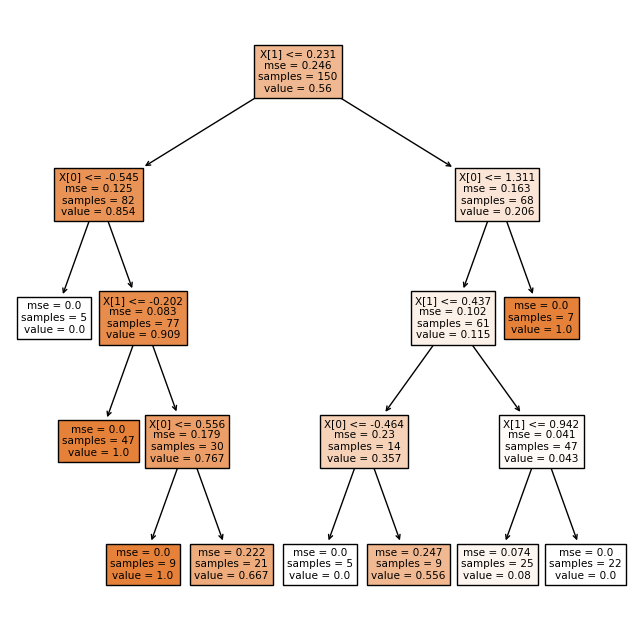

<Figure size 2500x2000 with 0 Axes>

In [210]:
from sklearn import tree
sns.reset_defaults() 
plt.figure(figsize=(8, 8))
clf = DecisionTreeRegressor(max_depth=4)
clf.fit(data_x, data_y)
tree.plot_tree(clf,filled = True,class_names=True)
plt.show()
fig = plt.figure(figsize=(25,20))



## Неустойчивость решающих деревьев

Решающие деревья — это алгоритмы, неустойчивые к изменениям обучающей выборки, т.е. при малейших её изменениях итоговый классификатор может радикально измениться.
Посмотрим, как будет меняться структура дерева при обучении на разных 90%-х подвыборках.


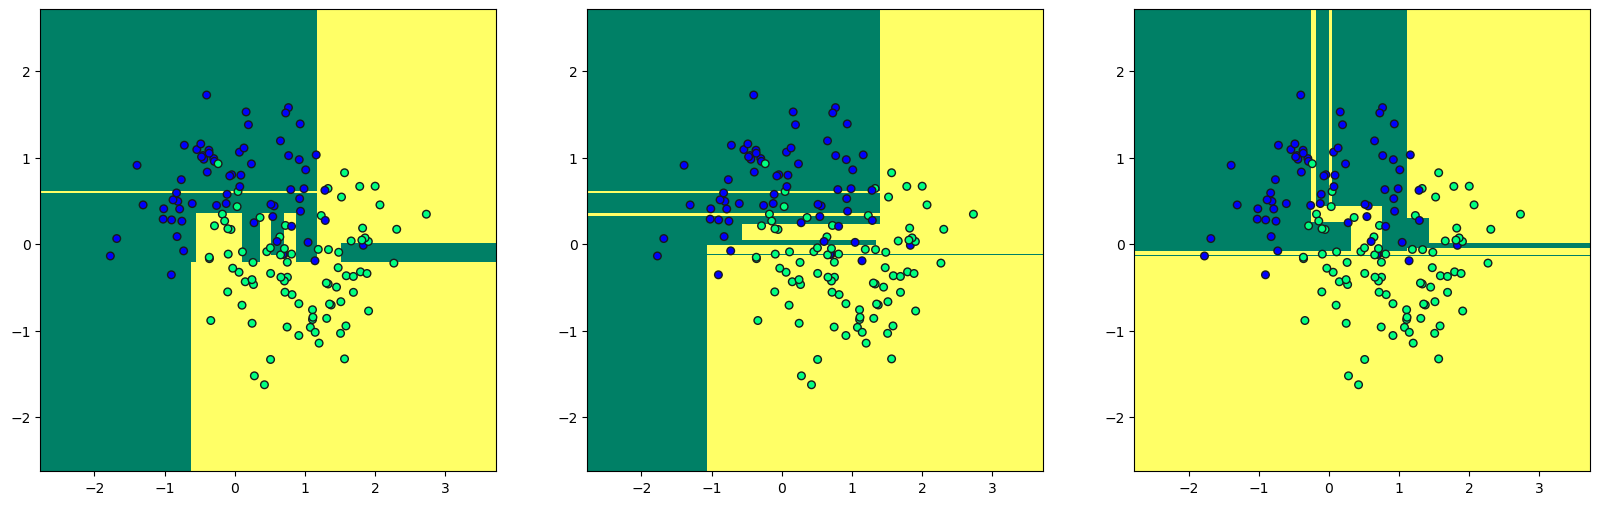

In [211]:
plt.figure(figsize=(20, 6))
for i in range(3):
    clf = DecisionTreeClassifier(random_state=42)

    indecies = np.random.randint(data_x.shape[0], size=int(data_x.shape[0] * 0.9))
    clf.fit(data_x[indecies], data_y[indecies])
    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plt.pcolormesh(xx, yy, predicted, cmap='summer')
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='winter', edgecolor='k')

Возможно, стоит, комбинировать различные решения для большей устойчиваости

# Композиции алгоритмов

## 1.  Стэкинг

Для стэкига моделей в sklearn реализованы классы:
    - ensemble.StackingRegressor(
    estimators, final_estimator=None, *, cv=None, n_jobs=None, passthrough=False, verbose=0)
    
    - ensemble.StackingClassifier(
    estimators, final_estimator=None, *, cv=None, stack_method='auto', n_jobs=None, passthrough=False, verbose=0)







#### Возьмем данные о стоимости недвижимости из датасета load_boston и построим самостоятельно блендинг( используя LinearRegression) 3х простых моделей. Не забываем, что настраивать веса линейной регрессии  нужно на отдельной от обучающей валидационной выборке.

In [249]:
from sklearn.datasets import load_boston
from sklearn.linear_model import RidgeCV,LassoCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
from utility import show_param_dependency,plot_predictions_2D
warnings.simplefilter("ignore")

data =load_boston()
X=pd.DataFrame(data.data,columns = data.feature_names)
y=data.target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,test_size=0.2, random_state=42
)

X_train2, X_val, y_train2, y_val = train_test_split(
    X_train, y_train,test_size=0.2, random_state=42
)

knn=KNeighborsRegressor(n_neighbors=2)
lr= LassoCV()
svr= LinearSVR(random_state=42)
estimators = [
    ('knn',knn),
    ('lr', lr),
    ('svr', svr)
]


x_est=pd.DataFrame()
mse_base=[]
for i,est in enumerate([knn,lr,svr]):
    est.fit(X_train2, y_train2)
    x_est[i]=est.predict(X_val)
    mse_base.append(mean_squared_error(est.predict(X_test),y_test).round(2))


#### Качество базовых моделей, вклад моделей в блендинг и MSE ансамбля:

In [250]:
print("MSE базовых регрессоров на тестовой выборке:",mse_base)  
final_est=LinearRegression(fit_intercept=False)
final_est.fit(x_est,y_val)
print("Коэффициенты базовых регрессоров в линейной регрессии блендинга:",final_est.coef_.round(2))
x_est2=pd.DataFrame()
for i,est in enumerate([knn,lr,svr]):
    x_est2[i]=est.predict(X_test)

y_pred=final_est.predict(x_est2)
print("Blending MSE=",mean_squared_error(y_test, y_pred).round(2))

MSE базовых регрессоров на тестовой выборке: [27.69, 24.5, 31.3]
Коэффициенты базовых регрессоров в линейной регрессии блендинга: [ 0.34  1.07 -0.4 ]
Blending MSE= 18.94


#### Видим, что ансамбль моделей работает заметно лучше каждой из них

#### Посмотрим, насколько скоррелированы предсказания различных моделей, а также степень близости матрицы базовых прогнозов к вырожденной.

число обусловленности матрицы прогнозов базовых алгоритмов= 31.37
Матрица корреляций:


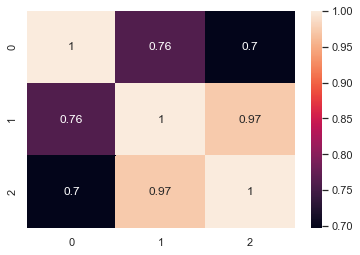

In [251]:
corrMatrix=pd.DataFrame(x_est2).corr()
sns.heatmap(corrMatrix, annot=True)
print("число обусловленности матрицы прогнозов базовых алгоритмов=",np.linalg.cond(x_est, p=None).round(2))
print("Матрица корреляций:")

#### Видим, что предсказания базовых моделей сильно скоррелированы, поэтому для устойчивости решения очень желательно использовать финальную модель с регуляризацией, например `RidgeCV`

#### Теперь воспользуемся готовым классом в sklearn для реализации стекинга, передадим в него `LinearRegression()` в качестве финальной модели:

In [252]:
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(fit_intercept=False),
    cv=10
)
reg.fit(X_train, y_train)
y_pred=reg.predict(X_test)
print("StackingRegressor MSE=",mean_squared_error(y_pred, y_test).round(2))
print("коэффициенты базовых моделей:",reg.final_estimator_.coef_)

StackingRegressor MSE= 19.51
коэффициенты базовых моделей: [ 0.21140782  0.81309808 -0.01589255]


## 2. Бэггинг и метод случайных подпространств

### Для реализации бэггинга  и метода случайных подпространств для произвольных алгоритмов регрессии в sklearn предлагается класс: 
sklearn.ensemble.BaggingRegressor
    base_estimator=None,
    n_estimators=10, *, 
    max_samples=1.0,
    max_features=1.0, 
    bootstrap=True, 
    bootstrap_features=False, 
    oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0)
    
   ##### значения параметров:
   - max_samples: основной параметр бэггинга, определяет долю или число объектов обучающей выборки в каждом 'пакете' объектов для обучения алгоритма base_estimator
   - bootstrap: при значении =True проводится случайный выбор с возвращением объекта в пул выбора, иначе без возвращения
   - max_features:необходим для реализации метода случайных подпространств, передаем долю или натуральное число семплируемых признаков (по умолчанию 1).
   - bootstrap_features - параметр в методе случайных подпространств, определяет,какого типа семплирование признаков - с возвращением или нет
   - oob_score: выполнять ли вневыборочную оценку модели
   
### Аналогично бэггинг и метод случайных подпространств в задачах классификации реализуем с помощью:
sklearn.ensemble.BaggingClassifier(
      base_estimator=None, 
      n_estimators=10, *,
      max_samples=1.0,
      max_features=1.0,
      bootstrap=True, 
      bootstrap_features=False, 
      oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0)
      
      
      
      
      


### Зависимость качества прогноза от параметров

Зафиксируем число моделей =40,выберем тип моделей -Беггинг решающих деревьев и посмотрим на графики зависимости MSE от числа семплируемых признаков обучающей выборки на каждый base-learner. Подберём на валидационной выборке (отделенной от обучающей) гиперпараметры бэггинга.

0| 8| 15| 23| 31| 38| 46| 54| 62| 69| 77| 85| 92| 100.0| 
Min MSE = 8.3949 for max_features=8


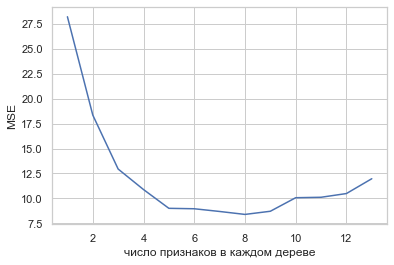

In [253]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.datasets import make_regression

#base_model=KNeighborsRegressor(n_neighbors=3)
#base_model=SVR(kernel='rbf',C=1000)
base_model=DecisionTreeRegressor()
num_basemodels=40
random_state=0
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train,
                                test_size=0.2,random_state=random_state)


regr = BaggingRegressor(base_estimator=base_model,max_samples=1.0,max_features=1.0,
                        n_estimators=num_basemodels, random_state=0)

show_param_dependency(regr, X_train2, y_train2, X_val, y_val, param_name='max_features', 
                      loss_fun='MSE', 
                      param_vals=np.arange(1,X_train2.shape[1]+1,1).round().astype('int'), 
                      x_label='число признаков в каждом дереве')

0| 10| 20| 30| 40| 50| 60| 70| 80| 90| 100.0| 
Min MSE = 7.6746 for max_samples=288


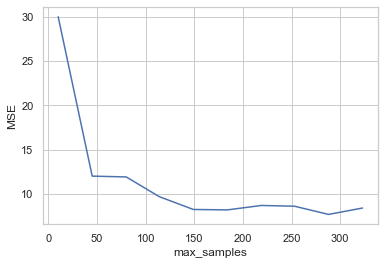

In [254]:
train_size=X_train2.shape[0]
regr = BaggingRegressor(base_estimator=base_model,max_samples=train_size,max_features=8,
                        n_estimators=num_basemodels, random_state=0,oob_score=True)

show_param_dependency(regr,  X_train2, y_train2, X_val, y_val, param_name='max_samples', 
                           loss_fun='MSE', param_vals=np.linspace(10,train_size,10).round().astype('int'), x_label='max_samples')



Теперь зафиксируем лучшие max_features,max_samples  и посмотрим на график зависимости MSE от числа семплируемых деревьев

0| 6| 12| 19| 25| 31| 38| 44| 50| 56| 62| 69| 75| 81| 88| 94| 100.0| 
Min MSE = 7.8409 for n_estimators=41


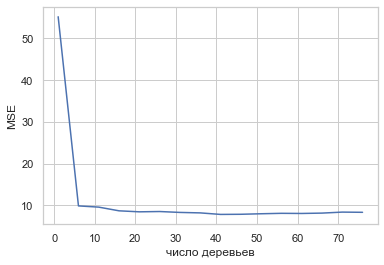

In [255]:
regr = BaggingRegressor(base_estimator=base_model,max_samples=288,max_features=8,
                        n_estimators=num_basemodels, random_state=0)
show_param_dependency(regr,  X_train2, y_train2, X_val, y_val, param_name='n_estimators', 
                           loss_fun='MSE', param_vals=np.arange(1,80,5), 
                           x_label='число деревьев')

In [256]:
regr = BaggingRegressor(base_estimator=base_model,max_samples=288,max_features=8,
                        n_estimators=41, random_state=0)
regr.fit(X_train2, y_train2)
y_pred=regr.predict(X_test)
print("BaggingRegressor  MSE=",mean_squared_error(y_pred, y_test).round(5))

BaggingRegressor  MSE= 12.57556


## Случайный лес
Для случайного леса в sklearn реализован класс 

sklearn.ensemble.RandomForestRegressor(n_estimators=100, ...)
    значения параметров:
    
    - max_samples: основной параметр бэггинга, определяет долю или число объектов обучающей выборки в каждом 'пакете' объектов для обучения алгоритма base_estimator
       
    - bootstrap: при значении True проводится случайный выбор с возвращением объекта в пул выбора, иначе без возвращения
    - max_features:необходим для реализации метода случайных подпространств, передаем долю или натуральное число семплируемых признаков (по умолчанию 1).


In [259]:
def plot_classifier_decision(classifier, X, y, plot_scatter=True, margin=0.1):
    x_range = X[:, 0].min() - margin, X[:, 0].max() + margin
    y_range = X[:, 1].min() - margin, X[:, 1].max() + margin
    xx, yy = numpy.meshgrid(numpy.linspace(*x_range, num=200),
                            numpy.linspace(*y_range, num=200))
    data = numpy.vstack([xx.flatten(), yy.flatten()]).T

    p = classifier.predict_proba(data)[:, 1]
    plt.contourf(xx, yy, p.reshape(xx.shape), cmap='bwr', alpha=.5)
    if plot_scatter:
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', s=30)

    plt.xlim(*x_range)
    plt.ylim(*y_range)
   

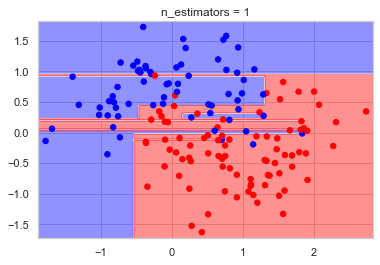

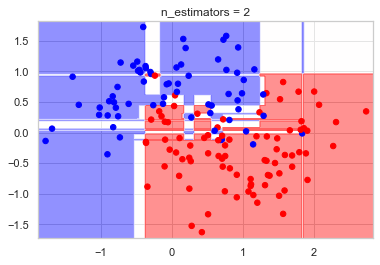

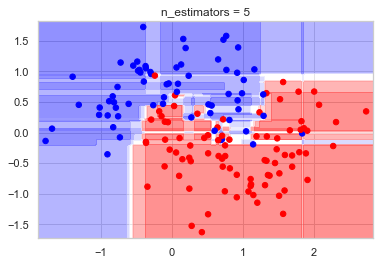

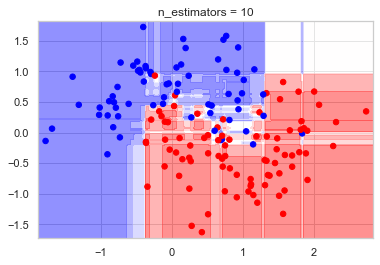

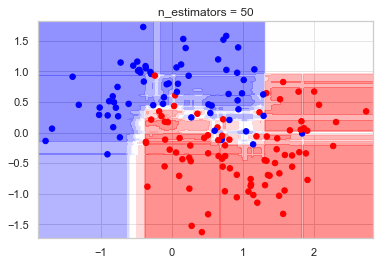

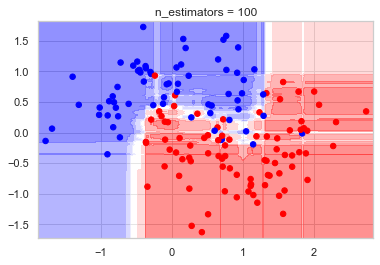

In [260]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
#plt.figure(figsize=(6,6))
for n_trees in [1, 2,5, 10, 50,100]:
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=2,warm_start=True).fit(data_x, data_y)
    plot_classifier_decision(rf,data_x, data_y)

    plt.title('n_estimators = {}'.format(n_trees))
    plt.show()

Найдем лучшее число случайно выбранных признаков max_features:

0| 8| 15| 23| 31| 38| 46| 54| 62| 69| 77| 85| 92| 100.0| 
Min MSE = 6.5544 for max_features=3


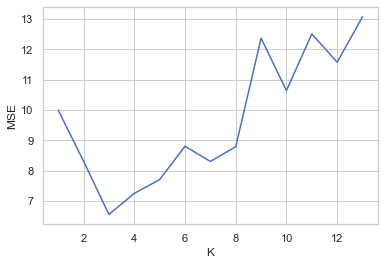

In [261]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=50,max_features=1.0,random_state=42)
show_param_dependency(regr, X_train2, y_train2, X_val, y_val, param_name='max_features', 
                        loss_fun='MSE', param_vals=np.arange(1,X_train2.shape[1]+1,1), x_label='K')

0| 9| 18| 27| 36| 45| 55| 64| 73| 82| 91| 100.0| 
Min MSE = 7.0453 for max_samples=271


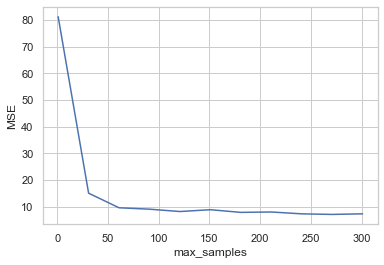

In [262]:
regr = RandomForestRegressor(n_estimators=50,max_features=3,random_state=42)
show_param_dependency(regr, X_train2, y_train2, X_val, y_val, param_name='max_samples', 
                        loss_fun='MSE', param_vals=np.arange(1,X_train2.shape[0],30), x_label='max_samples')

0| 10| 20| 30| 40| 50| 60| 70| 80| 90| 100.0| 
Min MSE = 6.1958 for n_estimators=89


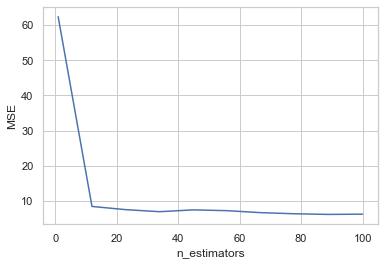

In [263]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=100,max_samples=271,max_features=3,random_state=0)
show_param_dependency(regr, X_train2, y_train2, X_val, y_val, param_name='n_estimators', 
                      loss_fun='MSE',
                      param_vals=np.linspace(1,100,10).round().astype('int'), x_label='n_estimators')

In [264]:
regr = RandomForestRegressor(n_estimators=89,max_samples=271,max_features=3,random_state=0)
regr.fit(X_train2, y_train2)

y_pred=regr.predict(X_test)
print("Random Forest Regressor  MSE=",mean_squared_error(y_pred, y_test).round(5))

Random Forest Regressor  MSE= 10.57054


## Градиентный бустинг

Интересный playgroung для представления работы бустинга решающих деревьев:
http://arogozhnikov.github.io/2016/07/05/gradient_boosting_playground.html

In [265]:
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier

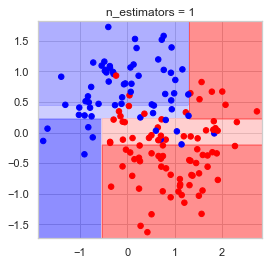

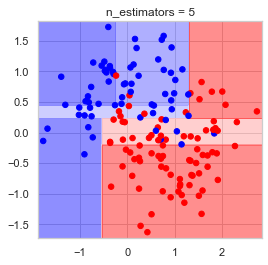

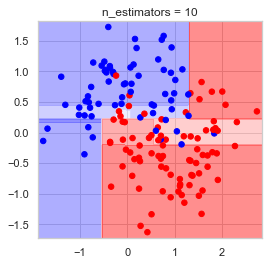

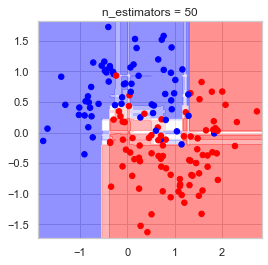

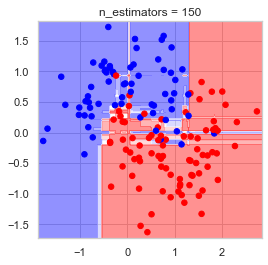

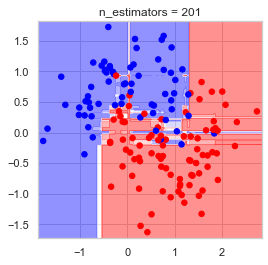

In [266]:

for n_trees in [1, 5,10, 50, 150,500]:
    plt.figure(figsize=(4,4))
    gb = GradientBoostingClassifier(n_estimators=n_trees,random_state=0,n_iter_no_change=200,
                                    warm_start=True).fit(data_x, data_y)
    plot_classifier_decision(gb,data_x, data_y)
  
    plt.title('n_estimators = {}'.format(gb.n_estimators_))
    plt.show()

Загрузим другой датасет для предсказания стоимости жилья (с большим числом признаков, чем в предыдущем датасете boston)

In [267]:
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
#### Загрузим датасет с большим числом признаков.
def load_ames_housing():
    df = fetch_openml(name="house_prices", as_frame=True)
    X = df.data
    y = df.target
    return X, np.log(y)
X, y = load_ames_housing()

#### Разделим данные на обучающую и тестовую выборки (20% тестовая).
random_state=42
from sklearn.model_selection import train_test_split
X_train_ames, X_test_ames, y_train_ames, y_test_ames = train_test_split(X, y, test_size=0.2,random_state=0)
numeric_data = X_train_ames.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
X_train_ames = X_train_ames.fillna(numeric_data_mean)
X_test_ames = X_test_ames.fillna(numeric_data_mean)

numeric_features = numeric_data.columns
categorical = list(X_train_ames.dtypes[X_train_ames.dtypes == "object"].index)
X_train_ames[categorical] = X_train_ames[categorical].fillna("NotGiven")
X_test_ames[categorical] = X_test_ames[categorical].fillna("NotGiven")
#### Применим ColumnTransformer для единообразной трансформации обучающей и тестовой выборки
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
])

X_train_ames=column_transformer.fit_transform(X_train_ames)
X_test_ames=column_transformer.transform(X_test_ames)

X_train_ames.shape

(1168, 263)

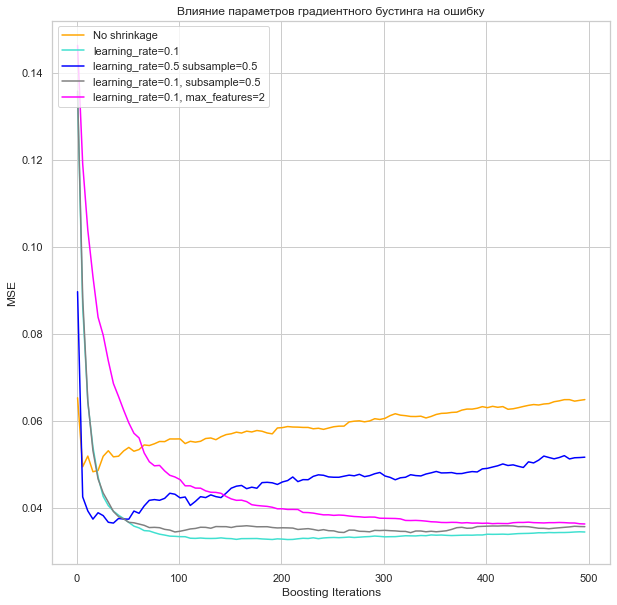

In [268]:
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import datasets

original_params = {
    "n_estimators": 500,
    "max_leaf_nodes": 4,
    "max_depth": None,
    "random_state": 2,
    "min_samples_split": 5,
}

plt.figure(figsize=(10,10))

for label, color, setting in [
    ("No shrinkage", "orange", {"learning_rate": 1.0, "subsample": 1.0}),
    ("learning_rate=0.1", "turquoise", {"learning_rate": 0.1, "subsample": 1.0}),
    ("learning_rate=0.5 subsample=0.5", "blue", {"learning_rate": 0.5, "subsample": 0.5}),
    (
        "learning_rate=0.1, subsample=0.5",
        "gray",
        {"learning_rate": 0.1, "subsample": 0.5},
    ),
    (
        "learning_rate=0.1, max_features=2",
        "magenta",
        {"learning_rate": 0.1, "max_features": 2},
    ),
]:
    params = dict(original_params)
    params.update(setting)

    clf = GradientBoostingRegressor(**params)
    clf.fit(X_train_ames, y_train_ames)

    # compute test set deviance
    test_deviance = np.zeros((params["n_estimators"],), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_predict(X_test_ames)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i] = mean_squared_error(y_test_ames, y_pred)

    plt.plot(
        (np.arange(test_deviance.shape[0]) + 1)[::5],
        test_deviance[::5],
        "-",
        color=color,
        label=label,
    )

plt.legend(loc="upper left")
plt.xlabel("Boosting Iterations")
plt.ylabel("MSE")
plt.title("Влияние параметров градиентного бустинга на ошибку")

plt.show()

Важность подбора параметров градиентного бустинга.

мы можем варьировать:
    - loss {‘squared_error’, ‘absolute_error’, ‘huber’, ‘quantile’}, default=’squared_error’
    - learning_rate : ограничивает вклад каждого последующего дерева
    - subsample - доля обучающей выборки, которую получает каждый base learner
    - max_depth ( default=3), можно уменьшить и получить град.бустинг решающих пней
    -max_features (число случайно выбранных признаков на каждом сплите)
    -warm_start - при повторном запуске fit() добавляет новых base-learner к предыдущему фиттингу модели
    - n_iter_no_change -останавливает обучение, если не было n_iter_no_change раз подряд улучшения loss(на валидационной части, тоже есть параметр)

# Значимость признаков

Посчитаем значимость признаков двумя способами:
1. с помощью класса permutation_importance (признак перемешивается)
2. через аттрибут feature_importances_ у модели случайного леса

Cравним значения на графиках

Вернемся для удобства иллюстрации к датасету с меньшим числом признаков

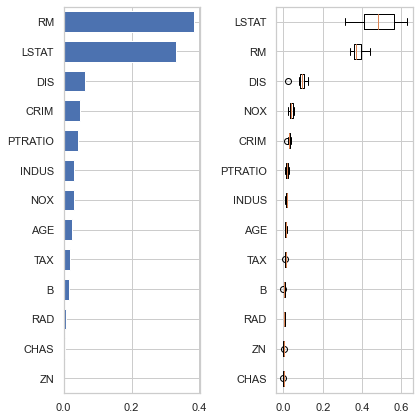

In [269]:

from sklearn.inspection import permutation_importance
regr = RandomForestRegressor(n_estimators=43,max_features=7,random_state=42).fit(X_train,y_train)
result = permutation_importance(regr, X_test, y_test, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(regr.feature_importances_)
tree_indices = np.arange(0, len(regr.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6))
ax1.barh(tree_indices, regr.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(X_test.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(regr.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False
    ,
    labels=X_test.columns[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

В данном случае разница очень небольшая, но для переобученных деревьев permutation_importance может давать более адекватную оценку важности признаков для модели

In [270]:
#посмотрим описание признаков
#print(data.DESCR)

Сравним для тех же данных значения коэффициентов регрессии и значимость, вычисленную с помощью класса permutation_importance. permutation_importance показывает, насколько важен признак для конкретной модели. 

1. Test MSE = 24.4239
2. Test MAE = 3.1761


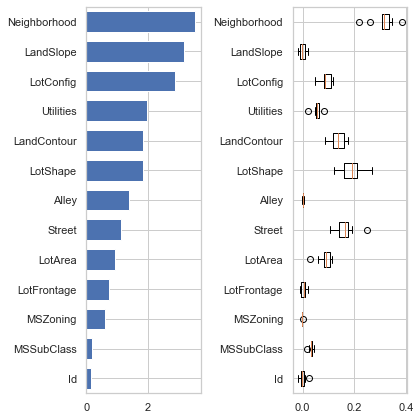

In [271]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

alphas=np.logspace(-3,3,50)
pipeline = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('reg', RidgeCV(alphas=alphas,scoring='neg_mean_squared_error'))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("1. Test MSE = %.4f" % mean_squared_error(y_test, y_pred))
print("2. Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))

coef= model['reg'].coef_
coef_named=pd.DataFrame(zip(X.columns,coef))
coef_named['abs']=abs(coef_named[1])
coef_named.sort_values(by='abs',axis=0,ascending=True,inplace=True)
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)


importance_sorted_idx = np.argsort(coef_named['abs'])
indices = np.arange(0, len(coef_named['abs'])) + 0.5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6))
ax1.barh(indices, coef_named['abs'], height=0.7)
ax1.set_yticks(indices)
ax1.set_yticklabels(X.columns[importance_sorted_idx])
ax1.set_ylim((0, len(coef_named['abs'])))
ax2.boxplot(
    result.importances[importance_sorted_idx].T,
    vert=False
    ,
    labels=X.columns[importance_sorted_idx],
)
fig.tight_layout()
plt.show()

In [272]:
#print(X_train.corr())

Можно обратить внимание, что признак B практически не важен для модели,модель почти не теряет в качестве без него.  Но именно из-за этого признака датасет load_boston был признан некорректным и будет исключен из следующих версий sklearn. В линейной регрессии признаку назначается значительный вес, потому что он сильно скоррелирован с таргетом.

1. Test MSE = 24.4239
2. Test MAE = 3.1761


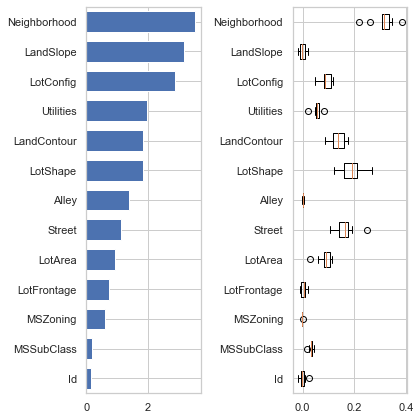

In [273]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

alphas=np.logspace(-3,3,50)
pipeline = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('reg', RidgeCV(alphas=alphas,scoring='neg_mean_squared_error'))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("1. Test MSE = %.4f" % mean_squared_error(y_test, y_pred))
print("2. Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))

coef= model['reg'].coef_
coef_named=pd.DataFrame(zip(X.columns,coef))
coef_named['abs']=abs(coef_named[1])
coef_named.sort_values(by='abs',axis=0,ascending=True,inplace=True)
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

importance_sorted_idx = np.argsort(coef_named['abs'])
indices = np.arange(0, len(coef_named['abs'])) + 0.5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6))
ax1.barh(indices, coef_named['abs'], height=0.7)
ax1.set_yticks(indices)
ax1.set_yticklabels(X.columns[importance_sorted_idx])
ax1.set_ylim((0, len(coef_named['abs'])))
ax2.boxplot(
    result.importances[importance_sorted_idx].T,
    vert=False
    ,
    labels=X.columns[importance_sorted_idx],
)
fig.tight_layout()
plt.show()

Случайный лес по сути вместо B чаще использует при сплитах другие признаки, значит признак B можно нелинейно выразить через другие, он не необходим для оптимального качества модели